In [1]:
%load_ext autoreload
%autoreload

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
import re
from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, TensorBoard
from keras import metrics


#plt.style.use('seaborn')
plt.style.use('ggplot')

Using TensorFlow backend.


Reads a subcategory of Amazon reviews into a pandas dataframe, and saves 2000 rows as a .pkl file.

Restarting Kernal while only running the following cell allows EDA without excessive memory use

In [7]:
#Set 'small_sample_pickled' to False to create'data/small_df.pkl'
small_sample_pickled = True

if not small_sample_pickled:
    df = pd.read_csv('data/gaming_reviews.tsv', sep='\t', error_bad_lines=False)
    df['text'] = df.review_headline + df.review_body
    
    #Drops any text that has a NaN
    #df = df[~df.text.isnull()].reset_index(drop=True)
    #df = df[['text', 'star_rating']]
    
    print(df.shape)
    df = df[0:10000]
    df.to_pickle('data/small_df.pkl')

b'Skipping line 20630: expected 15 fields, saw 22\nSkipping line 28172: expected 15 fields, saw 22\nSkipping line 54791: expected 15 fields, saw 22\n'
b'Skipping line 75419: expected 15 fields, saw 22\nSkipping line 104832: expected 15 fields, saw 22\n'
b'Skipping line 138464: expected 15 fields, saw 22\nSkipping line 194849: expected 15 fields, saw 22\n'
b'Skipping line 201568: expected 15 fields, saw 22\nSkipping line 242567: expected 15 fields, saw 22\n'
b'Skipping line 493585: expected 15 fields, saw 22\nSkipping line 502478: expected 15 fields, saw 22\n'
b'Skipping line 660750: expected 15 fields, saw 22\n'


(1780268, 16)


In [4]:
df = pd.read_pickle("data/small_df.pkl")
df.shape

(10000, 2)

In [6]:
df.iloc[1, :]

"Definitely a silent mouse... Not a single click was heardLoved it,  I didn't even realise it was a gaming mouse,  I typed in &#34;silent mouse&#34; and selected this one. It is perfect and looks pretty cool as well. Now my boyfriend's gaming is wonderfully comfortably silent :) . Think I might just get one for myself."

The review_headline and review_body columns will both be useful for prediction.
Review date might be useful as well, such as day of the week reviewed. 

Portions of ratings
1: 0.10
2: 0.04
3: 0.07
4: 0.13
5: 0.66


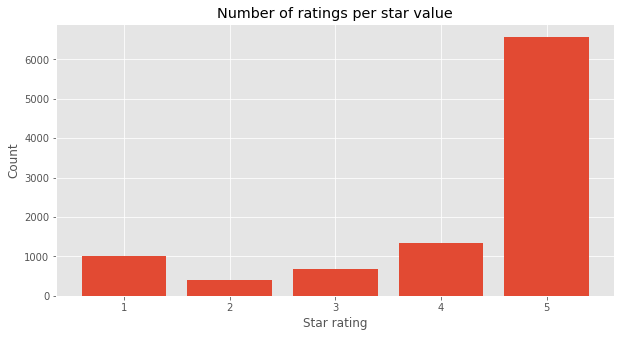

In [4]:
#Creates a list with the number of ratings per star
rating_count_list = []
possible_ratings = [1, 2, 3, 4, 5]

for rating in possible_ratings:
    rating_count_list.append(df[df['star_rating'] == rating].shape[0])
    
#Creates array that stores fraction of the total star values
rating_proportion = np.array(rating_count_list)/sum(rating_count_list)

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(possible_ratings, rating_count_list)

ax.set_xlabel('Star rating')
ax.set_ylabel('Count')
ax.set_title('Number of ratings per star value')

print('Portions of ratings')
print('1: {:0.2f}'.format(rating_proportion[0]))
print('2: {:0.2f}'.format(rating_proportion[1]))
print('3: {:0.2f}'.format(rating_proportion[2]))
print('4: {:0.2f}'.format(rating_proportion[3]))
print('5: {:0.2f}'.format(rating_proportion[4]))

In [5]:
strip_chars = ".?,!;:\"'()" 
rgx = re.compile('[%s]' % strip_chars)

def process_str(row):

    body_list = []
    try:
        for word in row.lower().split(): 
            body_list.append(rgx.sub('', word))
        return body_list
    except Exception as e:
        print(e)
        return ['']

In [6]:
#Count vectorizes text into a sparse vector
cv = CountVectorizer(strip_accents='ascii')
sparse_vec = cv.fit_transform(df.text)


In [7]:
def autoencoder_model(X_train):
    '''
    defines autoencoder model
    input: X_train (2D np array)
    output: autoencoder (compiled autoencoder model)
    '''
    # this is our input placeholder
    input_img = Input(shape=(X_train[0].shape[1],))

    # first encoding layer
    encoded1 = Dense(units = 256, activation = 'relu', name='layer1_256')(input_img)

    # second encoding layer
    # note that each layer is multiplied by the layer before
    encoded2 = Dense(units = 64, activation='relu', name='layer2_64')(encoded1)

    # first decoding layer
    decoded1 = Dense(units = 256, activation='relu', name='layer3_256')(encoded2)

    # second decoding layer - this produces the output
    decoded2 = Dense(units = X_train[0].shape[1], activation='sigmoid', name='layer4_output')(decoded1)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded2)

    # compile model
    autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])

    return autoencoder

In [8]:
#Train test split for small sample size
test_stop_index = int(sparse_vec.shape[0] * 0.1)
X_test = sparse_vec[0:test_stop_index]
y_test = np.array(df.star_rating)[0:test_stop_index]

X_train = sparse_vec[test_stop_index:]
y_train = np.array(df.star_rating)[test_stop_index:]

#One hot encoding star rating into array for transfer-learned neural net
enc = OneHotEncoder(categories='auto')
enc.fit(y_test.reshape(-1,1))
y_test = enc.transform(y_test.reshape(-1,1)).toarray()
y_train = enc.transform(y_train.reshape(-1,1)).toarray()

In [9]:
def batch_generator(X, batch_size, y=[]):
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(X)[0])
    np.random.shuffle(shuffle_index)
    
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[index_batch]
        X_batch = X_batch.toarray()
        counter += 1
        
        if y == []:
            yield X_batch, X_batch
        else:
            yield X_batch, y[index_batch]
        
        
        if (counter > number_of_batches):
            np.random.shuffle(shuffle_index)
            counter=0

In [10]:
autoencoder_model_created = True
model_path = 'models/basic_autoencoder1.h5'

if not autoencoder_model_created:
    model = autoencoder_model(X_train)

    batch_size = 1000
    nb_epoch = 10
    samples_per_epoch = 10

    # instantiate callbacks
    tensorboard = TensorBoard(log_dir='./autoencoder_logs', histogram_freq=2, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True)
    earlystopping = EarlyStopping(monitor='val_loss', patience=2)

    # try different number of epochs - 10 gives good performanace 
    """model.fit(X_train, X_train, epochs=10, batch_size=batch_size, verbose=1,
              validation_split=0.1, callbacks = [earlystopping, tensorboard])""" # cross val to estimate test error


    model.fit_generator(generator=batch_generator(X_train, batch_size),
                        epochs=nb_epoch,
                        samples_per_epoch=samples_per_epoch, validation_data=validation_generator)


    scores = model.evaluate(X_test, X_test)
    print('Test mse = {}'.format(scores[0]))

    X_test_decoded = model.predict(X_test)
    
    model.save(model_path)

else:
    model = load_model(model_path)
    scores = model.evaluate(X_test, X_test)
    print('Test mse = {}'.format(scores[0]))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


ValueError: Error when checking input: expected input_2 to have shape (10485,) but got array with shape (17275,)

In [ ]:
for i in range(4):
    print(model.layers[i].name)
    model.layers[i].trainable = False

In [ ]:
ll = model.layers[3].output
ll = Dense(units = 64, activation='relu', name='layer4_256')(ll)
ll = Dense(5,activation="hard_sigmoid", name='star_classification')(ll)
new_model = Model(inputs=model.input, outputs=ll)

new_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=[metrics.categorical_accuracy])

In [ ]:
batch_size = 500
nb_epoch = 15
samples_per_epoch = 10

# instantiate callbacks
tensorboard = TensorBoard(log_dir='./autoencoder_logs', histogram_freq=2, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=2)

# try different number of epochs - 10 gives good performanace 
"""model.fit(X_train, X_train, epochs=10, batch_size=batch_size, verbose=1,
          validation_split=0.1, callbacks = [earlystopping, tensorboard])""" # cross val to estimate test error


new_model.fit_generator(generator=batch_generator(X_train, batch_size, y_train),
                    epochs=nb_epoch,
                    steps_per_epoch=samples_per_epoch)


scores = new_model.evaluate(X_test, y_test)
print('Test accuracy = {}'.format(scores[1]))

X_test_decoded = new_model.predict(X_test)

model.save(model_path)

In [ ]:
y_pred = new_model.predict_on_batch(X_test.toarray())
y_pred[0:10]


In [11]:
y_pred

NameError: name 'y_pred' is not defined

In [12]:
X_test.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [13]:
y_test

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [14]:
enc = OneHotEncoder()
enc.fit(y_test.reshape(-1,1))
enc.transform(y_test.reshape(-1,1)).toarray()
enc.transform(y_train.reshape(-1,1)).toarray()

/home/tyler/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])